#Movie-Recommendation System 

##Importing Standard library

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.sparse as sp
# !pip install matrix_factorization
import matrix_factorization
from math import sqrt
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors

##Data-preprocessing

In [2]:
rating=pd.read_csv("C:/Users/samya/Downloads/archive/ratings.csv")
rating=rating.drop('timestamp',axis=1)
rating

,userId,movieId,rating
0,1,169,2.5
1,1,2471,3.0
2,1,48516,5.0
3,2,2571,3.5
4,2,109487,4.0
...,...,...,...
22884372,247753,49530,5.0
22884373,247753,69481,3.0
22884374,247753,74458,4.0
22884375,247753,76093,5.0


In [3]:
movies=pd.read_csv("C:/Users/samya/Downloads/archive/movies.csv")
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
34203,151697,Grand Slam (1967),Thriller
34204,151701,Bloodmoney (2010),(no genres listed)
34205,151703,The Butterfly Circus (2009),Drama
34206,151709,Zero (2015),Drama|Sci-Fi


In [4]:
tags=pd.read_csv("C:/Users/samya/Downloads/archive/tags.csv")
tags=tags.drop('timestamp',axis=1)
tags

,userId,movieId,tag
0,19,2324,bittersweet
1,19,2324,holocaust
2,19,2324,World War II
3,23,7075,hilarious
4,23,7075,Underrated
...,...,...,...
586989,247751,96655,future
586990,247751,96655,robots
586991,247753,356,classic
586992,247753,356,oscar (best supporting actor)


In [5]:
# Checking if the user has rated the same movie twice, in that case we just take max of them
ratings_df = rating.groupby(['userId','movieId']).aggregate(np.max)


In [6]:
ratings_df.shape

(22884377, 1)

In [7]:
ratings_df.head()

rating
userId movieId        
1      169         2.5
       2471        3.0
       48516       5.0
2      2571        3.5
       109487      4.0

##Genre Based Movie classification method

In [8]:
# Counting no of unique users and movies
n_users=len(rating['userId'].unique())
n_movies=len(rating['movieId'].unique())
print(f'The number of unique users are {n_users}')
print(f'The number of unique movies are {n_movies}')

#Calculating the sparsity
sparsity = round(1.0 - len(rating)/(1.0*(n_movies*n_users)),3)
print(sparsity)

The number of unique users are 247753
The number of unique movies are 33670
0.997


In [9]:
genre=movies["genres"]
genre.head()

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

In [10]:
genre_list = ""
for index,row in movies.iterrows():
        genre_list += row.genres + "|"
#split the string into a list of values
genre_list_split = genre_list.split('|')
#de-duplicate values
new_list = list(set(genre_list_split))
#remove the value that is blank
new_list.remove('')
#inspect list of genres
print(new_list)

['Comedy', 'War', 'Drama', 'Crime', 'Musical', 'Mystery', 'Children', 'Western', 'Action', 'IMAX', 'Horror', 'Romance', 'Documentary', 'Animation', 'Adventure', 'Fantasy', '(no genres listed)', 'Thriller', 'Film-Noir', 'Sci-Fi']


In [11]:
print(f'The number of genres are {len(new_list)}')

The number of genres are 20


In [12]:
#Enriching the movies dataset by adding the various genres columns.
movies_genres = movies.copy()

for genre in new_list :
    movies_genres[genre] = movies_genres.apply(lambda _:int(genre in _.genres), axis = 1)
# movies_genres=movies_genres.drop("genres",axis=1)

In [13]:
movies_genres.head()

,movieId,title,genres,Comedy,War,Drama,Crime,Musical,Mystery,Children,...,Horror,Romance,Documentary,Animation,Adventure,Fantasy,(no genres listed),Thriller,Film-Noir,Sci-Fi
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,0,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Finding the average rating for movie and the number of ratings for each movie
avg_movie_rating = pd.DataFrame(rating.groupby('movieId')['rating'].agg(['mean','count']))
# avg_movie_rating['movieId']= avg_movie_rating.index
avg_movie_rating.head()

,mean,count
movieId,,
1,3.894802,60424
2,3.221086,23950
3,3.180094,15267
4,2.879727,2935
5,3.080811,14769


In [15]:
no_user_voted = rating.groupby('movieId')['rating'].agg('count')
no_movies_voted = rating.groupby('userId')['rating'].agg('count')
print(type(no_user_voted[:5]))
no_movies_voted[:5]


<class 'pandas.core.series.Series'>


userId
1      3
2      4
3      4
4    183
5     25
Name: rating, dtype: int64

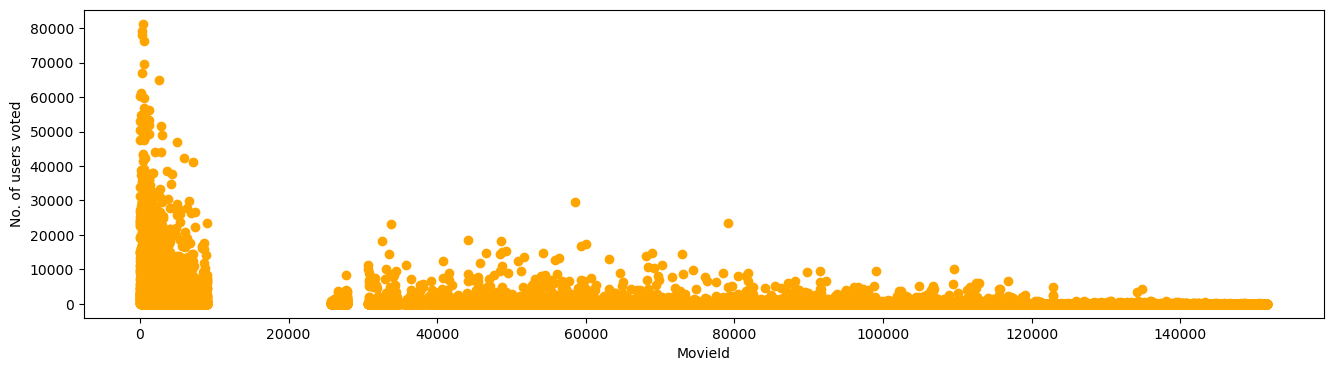

In [19]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='orange')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

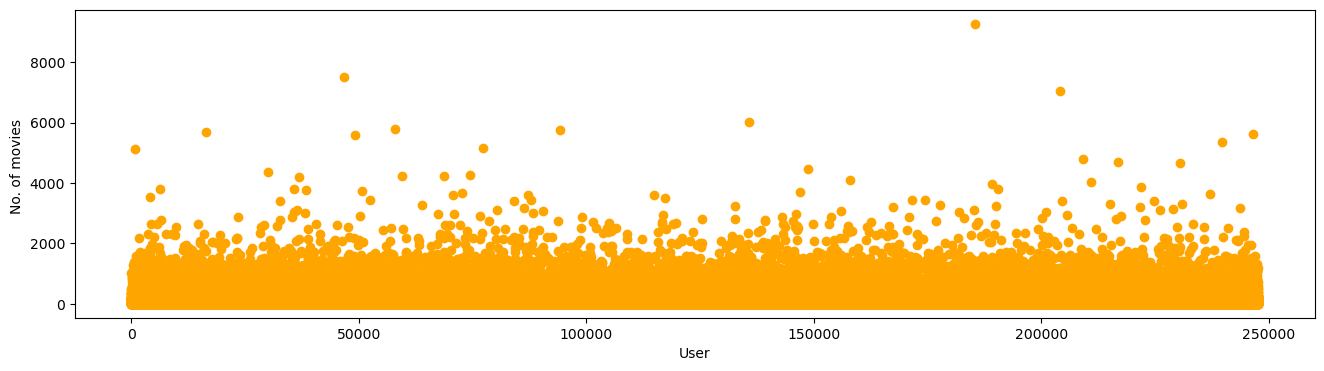

In [20]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_movies_voted.index,no_movies_voted,color='orange')
plt.xlabel('User')
plt.ylabel('No. of movies ')
plt.show()

In [21]:
# avg_movie_rating.drop("movieId",axis=1)

In [22]:
avg_movie_rating.shape

(33670, 2)

In [23]:
#calculate the percentile count. It gives the no of ratings at least 65% of the movies have
min_count=np.percentile(avg_movie_rating['count'],65)
min_count

43.0

In [24]:
#Get the average movie rating across all movies 
avg_rating_all=rating['rating'].mean()
avg_rating_all

3.5260770044122243

In [25]:
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_count]
movie_score.head()

,mean,count
movieId,,
1,3.894802,60424
2,3.221086,23950
3,3.180094,15267
4,2.879727,2935
5,3.080811,14769


In [26]:
movie_score.shape

(11750, 2)

In [27]:
#create a function for weighted rating score based off count of reviews
def weighted_rating(x, m=min_count, C=avg_rating_all):
    v = x['count']
    R = x['mean']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [28]:
for index, row in movie_score.iterrows():
    weighted_score = weighted_rating(row)
    movie_score.loc[index, 'weighted_score'] = weighted_score

movie_score.head()


C:\Users\samya\AppData\Local\Temp\ipykernel_24220\205697544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_score.loc[index, 'weighted_score'] = weighted_score


,mean,count,weighted_score
movieId,,,
1,3.894802,60424,3.894540
2,3.221086,23950,3.221632
3,3.180094,15267,3.181066
4,2.879727,2935,2.889060
5,3.080811,14769,3.082104


In [29]:
#join movie details to movie ratings
movie_score = pd.merge(movie_score,movies_genres,on='movieId')
#join movie links to movie ratings
#movie_score = pd.merge(movie_score,links,on='movieId')
movie_score.head()

,movieId,mean,count,weighted_score,title,genres,Comedy,War,Drama,Crime,...,Horror,Romance,Documentary,Animation,Adventure,Fantasy,(no genres listed),Thriller,Film-Noir,Sci-Fi
0,1,3.894802,60424,3.894540,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,0,0,0,...,0,0,0,1,1,1,0,0,0,0
1,2,3.221086,23950,3.221632,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,3,3.180094,15267,3.181066,Grumpier Old Men (1995),Comedy|Romance,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,4,2.879727,2935,2.889060,Waiting to Exhale (1995),Comedy|Drama|Romance,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,5,3.080811,14769,3.082104,Father of the Bride Part II (1995),Comedy,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

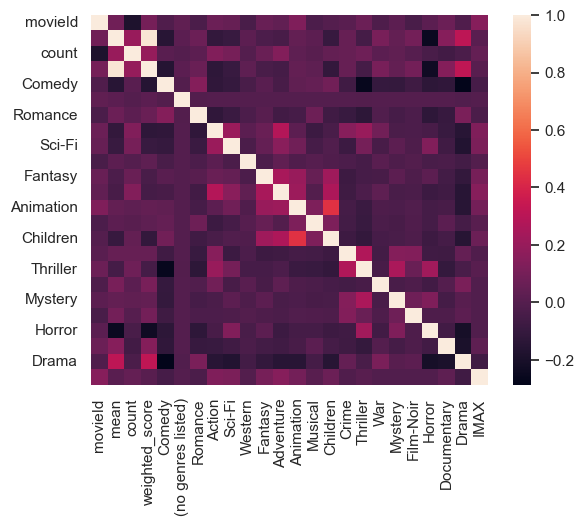

In [427]:
# correlation between the different parameters
tc = movie_score.corr()
 
# plot a heatmap of the correlated data
sns.heatmap(tc)


In [30]:
movie_score.shape

(11750, 26)

In [31]:
#list top scored movies over the whole range of movies
pd.DataFrame(movie_score.sort_values(['weighted_score'], ascending=False)[['title', 'count', 'mean', 'weighted_score', 'genres']])


,title,count,mean,weighted_score,genres
307,"Shawshank Redemption, The (1994)",77887,4.441710,4.441205,Crime|Drama
783,"Godfather, The (1972)",49846,4.353639,4.352926,Crime|Drama
49,"Usual Suspects, The (1995)",53195,4.318987,4.318346,Crime|Mystery|Thriller
509,Schindler's List (1993),59857,4.290952,4.290403,Drama|War
1111,"Godfather: Part II, The (1974)",32247,4.268878,4.267889,Crime|Drama
...,...,...,...,...,...
1615,Barney's Great Adventure (1998),432,1.197917,1.408676,Adventure|Children
5828,Gigli (2003),741,1.170715,1.299900,Comedy|Crime|Romance
7106,SuperBabies: Baby Geniuses 2 (2004),219,0.851598,1.290539,Comedy
4333,Glitter (2001),713,1.135344,1.271324,Drama|Musical|Romance


<AxesSubplot:xlabel='title', ylabel='count'>

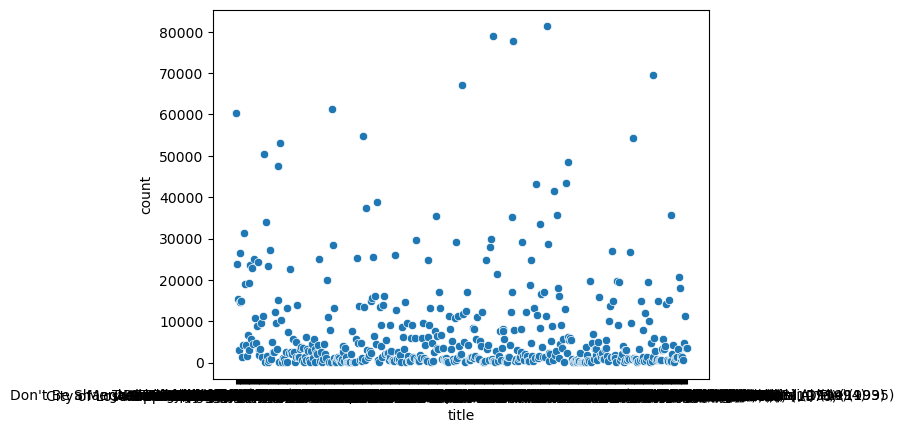

In [32]:
sns.scatterplot(data=movie_score[:500], x="title", y="count")


In [33]:
# Gives the best movies according to genre based on weighted score which is calculated using IMDB formula
def best_movies_by_genre(genre,top_n):
    return pd.DataFrame(movie_score.loc[(movie_score[genre]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']][:top_n])

In [34]:
best_movies_by_genre("Crime",5)

,title,count,mean,weighted_score
307,"Shawshank Redemption, The (1994)",77887,4.441710,4.441205
783,"Godfather, The (1972)",49846,4.353639,4.352926
49,"Usual Suspects, The (1995)",53195,4.318987,4.318346
1111,"Godfather: Part II, The (1974)",32247,4.268878,4.267889
2686,Fight Club (1999),48879,4.233925,4.233302


##Movie Recommendation Based on other viewers choice

In [35]:
#merging ratings and movies dataframes
ratings_movies = pd.merge(rating,movies, on = 'movieId')

In [36]:
ratings_movies.head()

,userId,movieId,rating,title,genres
0,1,169,2.5,Free Willy 2: The Adventure Home (1995),Adventure|Children|Drama
1,13,169,1.0,Free Willy 2: The Adventure Home (1995),Adventure|Children|Drama
2,14,169,3.0,Free Willy 2: The Adventure Home (1995),Adventure|Children|Drama
3,17,169,1.0,Free Willy 2: The Adventure Home (1995),Adventure|Children|Drama
4,68,169,1.0,Free Willy 2: The Adventure Home (1995),Adventure|Children|Drama


In [37]:
ratings_movies.shape

(22884377, 5)

In [38]:
#Gets the other top 10 movies which are watched by the people who saw this particular movie
def get_other_movies(movie_name):
    #get all users who watched a specific movie
    df_movie_users_series = ratings_movies.loc[ratings_movies['title']==movie_name]['userId']
    #convert to a data frame
    df_movie_users = pd.DataFrame(df_movie_users_series,columns=['userId'])
    #get a list of all other movies watched by these users
    other_movies = pd.merge(df_movie_users,ratings_movies,on='userId')
    #get a list of the most commonly watched movies by these other user
    other_users_watched = pd.DataFrame(other_movies.groupby('title')['userId'].count()).sort_values('userId',ascending=False)
    other_users_watched['Percentage_who_watched'] = round(other_users_watched['userId']*100/other_users_watched['userId'][0],1)
    return other_users_watched[:10]

In [39]:
# # Getting other top 10 movies which are watched by the people
get_other_movies('Jumanji (1995)')

,userId,Percentage_who_watched
title,,
Jumanji (1995),23950,100.0
Jurassic Park (1993),19172,80.1
Forrest Gump (1994),18870,78.8
Pulp Fiction (1994),16656,69.5
"Lion King, The (1994)",16199,67.6
Terminator 2: Judgment Day (1991),16156,67.5
"Silence of the Lambs, The (1991)",16052,67.0
"Mask, The (1994)",15692,65.5
Braveheart (1995),15520,64.8


##Movie-recommendation based on the content of the movie

In [40]:
#Getting the movies list with only genres like Musical and other such columns
movie_content_df_temp = movies_genres.copy()
movie_content_df_temp.set_index('movieId')
movie_content_df = movie_content_df_temp.drop(columns = ['movieId','title','genres'])
movie_content_df = movie_content_df.values
movie_content_df

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [41]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(movie_content_df,movie_content_df)

In [42]:
# Similarity of the movies based on the content
cosine_sim

array([[5., 3., 1., ..., 0., 0., 0.],
       [3., 3., 0., ..., 0., 0., 0.],
       [1., 0., 2., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 2., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [43]:
#create a series of the movie id and title
indicies = pd.Series(movie_content_df_temp.index, movie_content_df_temp['title'])
indicies 

title
Toy Story (1995)                          0
Jumanji (1995)                            1
Grumpier Old Men (1995)                   2
Waiting to Exhale (1995)                  3
Father of the Bride Part II (1995)        4
                                      ...  
Grand Slam (1967)                     34203
Bloodmoney (2010)                     34204
The Butterfly Circus (2009)           34205
Zero (2015)                           34206
The 2000 Year Old Man (1975)          34207
Length: 34208, dtype: int64

In [44]:
#Gets the top 10 similar movies based on the content
def get_movies_content(name) :
    movie_index=indicies[name]
    sim_scores = list(enumerate(cosine_sim[movie_index]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
   
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[0:11]
#     print(sim_scores)
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
#     print(movie_indices)
    similar_movies = pd.DataFrame(movie_content_df_temp[['title','genres']].iloc[movie_indices])
    return similar_movies

In [45]:
mv="Toy Story (1995)"
get_movies_content(mv)

,title,genres
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
664,Space Jam (1996),Adventure|Animation|Children|Comedy|Fantasy|Sc...
2210,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
2902,Who Framed Roger Rabbit? (1988),Adventure|Animation|Children|Comedy|Crime|Fant...
3028,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
3664,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
3923,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
4212,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
4791,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
7815,"Chipmunk Adventure, The (1987)",Adventure|Animation|Children|Comedy|Fantasy|Mu...


##Nearest neighbor implementaion to recommend movie.

In [46]:
avg_movie_rating.head()
    

,mean,count
movieId,,
1,3.894802,60424
2,3.221086,23950
3,3.180094,15267
4,2.879727,2935
5,3.080811,14769


In [47]:
#only include movies with more than min ratings
movie_plus_ratings = avg_movie_rating.loc[avg_movie_rating['count']>=min_count]
print(len(movie_plus_ratings))

11824


In [48]:
movie_plus_ratings

,mean,count
movieId,,
1,3.894802,60424
2,3.221086,23950
3,3.180094,15267
4,2.879727,2935
5,3.080811,14769
...,...,...
148238,2.457944,107
148626,3.938406,276
148652,2.318750,80


In [49]:
filtered_ratings = pd.merge(movie_plus_ratings, rating, on="movieId")
len(filtered_ratings)

22715821

In [50]:
filtered_ratings=filtered_ratings[:10000000]

In [51]:
#create a matrix table with movieIds on the rows and userIds in the columns.
#replace NAN values with 0
movie_wide = filtered_ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
movie_wide.head()

userId,1,3,4,5,6,7,8,9,10,11,...,247744,247745,247746,247747,247748,247749,247750,247751,247752,247753
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [52]:
#specify model parameters
model_knn = NearestNeighbors(metric='cosine',algorithm='brute')
#fit model to the data set
model_knn.fit(movie_wide)
movie_wide

userId,1,3,4,5,6,7,8,9,10,11,...,247744,247745,247746,247747,247748,247749,247750,247751,247752,247753
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1916,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
#Gets the top 10 nearest neighbours got the movie
def print_similar_movies(name) :
    #get the list of user ratings for a specific userId
    query_index=np.where(movies_genres['title'].to_numpy()==name)[0][0]
#     print(query_index)
    query_index_movie_ratings = movie_wide.iloc[query_index,:].values.reshape(1,-1)
    #get the closest 10 movies and their distances from the movie specified
    distances,indices = model_knn.kneighbors(query_index_movie_ratings,n_neighbors = 11) 
    #write a lopp that prints the similar movies for a specified movie.
    for i in range(0,len(distances.flatten())):
        #get the title of the random movie that was chosen
        get_movie = movies.loc[movies['movieId']==query_index]['title']
        #for the first movie in the list i.e closest print the title
        if i==0:
            print('Recommendations for {0}:\n'.format(get_movie))
        else :
            #get the indiciees for the closest movies
            indices_flat = indices.flatten()[i]
            #get the title of the movie
            get_movie = movies.loc[movies['movieId']==movie_wide.iloc[indices_flat,:].name]['title']
            #print the movie
            print('{0}: {1}, with distance of {2}:'.format(i,get_movie,distances.flatten()[i]))

In [54]:
print_similar_movies("Toy Story (1995)")

Recommendations for Series([], Name: title, dtype: object):

1: 257    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object, with distance of 0.4533250097839031:
2: 767    Independence Day (a.k.a. ID4) (1996)
Name: title, dtype: object, with distance of 0.4538558575097593:
3: 1242    Back to the Future (1985)
Name: title, dtype: object, with distance of 0.48366108289543175:
4: 640    Mission: Impossible (1996)
Name: title, dtype: object, with distance of 0.48794872482279006:
5: 352    Forrest Gump (1994)
Name: title, dtype: object, with distance of 0.4922356953989341:
6: 476    Jurassic Park (1993)
Name: title, dtype: object, with distance of 0.49415268801940737:
7: 1052    Willy Wonka & the Chocolate Factory (1971)
Name: title, dtype: object, with distance of 0.5009391786959606:
8: 1184    Star Wars: Episode VI - Return of the Jedi (1983)
Name: title, dtype: object, with distance of 0.5018283714540219:
9: 360    Lion King, The (1994)
Name: title, dtype: object, with di

In [55]:
np.where(movies_genres['title'].to_numpy()=='Toy Story (1995)')

(array([0], dtype=int64),)

##Overall compilation of the above mentioned systems

In [56]:
def recommend(name):
    content=get_movies_content(name)
    print(f'Based on the movies content, top movies are: {content}')
    people=get_other_movies(name)
    print(f"Based on other peoples watching, top movies are:{people}")
    print(f"Similar movies based on current movie")   
    print_similar_movies(name)
    

#User-Input

In [58]:
User_choice=input("Do you want recommendation based on genre? y/n")
if(User_choice=='y'):
    print(f"The genres available are:{new_list}")
    genre_choice=input("Choose your genre")    
    moc=best_movies_by_genre(str(genre_choice),5)
    print(moc)
else:
    user_input_movie=input("Enter the movie of your choice")
    recommend(user_input_movie)
    

Do you want recommendation based on genre? y/nn
Enter the movie of your choiceLion King, The (1994)
Based on the movies content, top movies are:                                                   title  \
360                               Lion King, The (1994)   
1631                                   Anastasia (1997)   
1824                                       Mulan (1998)   
8605  Wonderful World of the Brothers Grimm, The (1962)   
47                                    Pocahontas (1995)   
582                                      Aladdin (1992)   
588              Snow White and the Seven Dwarfs (1937)   
589                         Beauty and the Beast (1991)   
624                      All Dogs Go to Heaven 2 (1996)   
653                    James and the Giant Peach (1996)   
697                             Oliver & Company (1988)   

                                                 genres  
360     Adventure|Animation|Children|Drama|Musical|IMAX  
1631         Adventure|Animati

In [ ]:
# x = input()
# best_movies_by_genre(x,5)